In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import os
import pandas as pd
import numpy as np
import sys
import pickle
from scipy.spatial.distance import cdist
import math
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadag
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import mygene
import re


Bad key "scatter.edgecolors" on line 12 in
/cellar/users/samsonfong/.config/matplotlib/stylelib/custom1.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "lines.markeredgecolor" on line 10 in
/cellar/users/samsonfong/.config/matplotlib/stylelib/custom1.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def load_network(network_file_list, valid_gene_list):
    
    gene_neighbor_map = {}
    
    for file_name in network_file_list:
        
        print 'Load network', file_name
        
        file_handle = open(file_name)
    
        for line in file_handle:
        
            line = line.rstrip().split()
            gene1, gene2 = line[0], line[1]
        
            if gene1 not in valid_gene_list or gene2 not in valid_gene_list:
                continue
        
            if gene1 not in gene_neighbor_map:
                gene_neighbor_map[gene1] = set()
            if gene2 not in gene_neighbor_map:
                gene_neighbor_map[gene2] = set()
            
            gene_neighbor_map[gene1].add(gene2)
            gene_neighbor_map[gene2].add(gene1)
            
        file_handle.close()
    
    return gene_neighbor_map
                             
def load_name_space():
        
    go_tab_map = {}
    
    file_handle = open(go_name_space_file)
    
    for line in file_handle:
        line = line.rstrip().split()
        go_tab_map[line[0]] = line[1]
        
    file_handle.close()
    
    return go_tab_map
        
def list2index(cell_line_list, cell_line2id):
    
    cell_line_idx_list = []
    
    for cell_line in cell_line_list:
        cell_line_idx_list.append(cell_line2id[cell_line])
        
    return np.asarray(cell_line_idx_list)

In [3]:
data_file = '/cellar/users/majianzhu/CancerDrug/sanger_cell_line_data/'
new_network_file = '/cellar/users/majianzhu/CancerDrug/networks/'

exp_data_file = data_file + 'Cell_line_RMA_proc_basalExp.txt'

drug_cell_line_file = data_file + 'v17_fitted_dose_response.csv'
cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
mutation_data_file = data_file + 'WES_variants.csv'
drug_target_file = data_file + 'drug_target_list'

feature_folder = 'feature/'

inbiomap_file = 'InBio-Map_Symbol.sif'
pathwaycomm_file = 'PathwayCommons9.txt'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

In [4]:
exp_df = pd.read_csv(exp_data_file, sep='\t', index_col=0)
exp_df = exp_df.T[1:]
exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
exp_df = exp_df.drop('NO_GENE_NAME',axis=1)

def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))

exp_df.index = exp_df.index.map(stripNumber)
exp_df = exp_df.groupby(level=0).first()

exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())

print len(exp_cell_line_list), len(exp_gene_list)

exp_df

1014 17419


GENE_SYMBOLS,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00514,OR1D5,ZNF234,MYH4,LINC00526,PPY2,KRT18P55,POLRMTP1,UBL5P2,TBC1D3P5
683665,3.238273,2.982254,10.235491,4.856061,4.078870,9.116236,3.658590,6.145475,5.042464,5.438402,...,3.103752,3.724013,3.981948,2.823245,5.866047,3.095716,3.274367,3.056214,9.446305,3.530871
683667,7.780713,2.753253,9.960137,4.351073,3.716740,3.222277,8.221606,3.823474,4.756228,5.805642,...,3.175476,3.779354,4.504481,2.690651,3.347520,3.230713,3.102091,3.169188,9.810430,3.266915
684052,7.301344,2.890533,9.922489,4.125088,3.678987,3.096576,3.588391,4.809305,4.951782,5.089165,...,3.299300,3.762301,4.177345,2.499803,5.054260,3.003521,3.068187,3.135479,9.073222,3.098364
684055,8.690198,3.091473,9.992487,4.572198,3.333385,3.320793,3.159487,3.515105,5.446361,5.348338,...,3.251885,2.929491,4.702208,2.489674,5.097089,3.114744,3.119647,3.194925,9.013220,3.074187
684057,8.233101,2.824687,10.015884,4.749715,3.839433,3.142754,5.329830,3.272124,5.538055,6.428482,...,3.081750,3.226083,4.666295,2.491254,6.261573,3.031862,3.322455,2.813440,8.893197,3.266184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660036,7.797699,2.640900,9.463400,4.039697,3.854522,3.212820,3.369225,8.969264,6.660734,4.942390,...,6.654799,3.734381,4.158913,2.849266,4.772469,3.101758,3.662190,3.329809,9.491964,3.317055
1674021,7.606903,3.157319,10.153141,3.768090,3.502940,3.219493,3.353777,7.774275,6.146783,5.429215,...,8.123459,3.467924,3.862499,2.835317,3.329585,3.193906,4.152130,3.332182,8.826412,3.852447
1723793,7.247670,2.759430,10.381303,4.596494,4.101198,3.442188,4.684189,8.540689,5.466290,5.798390,...,3.122087,3.409170,3.989737,2.488525,4.011168,2.934818,3.472314,3.122506,9.534718,3.543271
1723794,6.978150,2.892534,10.203625,3.867890,3.962809,3.562039,3.198608,9.053622,5.309724,5.795402,...,3.177008,3.247534,4.005281,2.484837,4.825418,2.989489,3.139941,3.128112,10.346289,3.192360


In [5]:
maf = pd.read_csv(mutation_data_file, sep='\t', index_col=0).fillna(0)
mutation_df = maf.groupby(['COSMIC_ID', 'Gene']).size().unstack().fillna(0).clip_upper(1)
mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())

print len(mutation_cell_line_list), len(mutation_gene_list)

mutation_df

/cellar/users/samsonfong/bin/miniconda/envs/tcrp/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/cellar/users/samsonfong/bin/miniconda/envs/tcrp/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  


1001 19100


Gene,A1BG,A1CF,A2M,A2ML1,A4D226,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hCG_17324,hsa-mir-4763
COSMIC_ID,,,,,,,,,,,,,,,,,,,,,
683665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
683667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1660035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1660036,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
file_handle = open(drug_target_file)

drug_target_map = {}
drug_target_list = []

for line in file_handle:
    
    drug, target_list_str = line.rstrip().split('|')
    drug = drug.strip()
    
    drug_target_map[drug] = []
    
    if ',' not in target_list_str:
        drug_target_map[drug].append(target_list_str.strip())
        drug_target_list.append(target_list_str.strip())
    else:
        target_list = target_list_str.split(',')
        for target in target_list:
            drug_target_map[drug].append(target.strip())
            drug_target_list.append(target.strip())

print len(drug_target_list)
print drug_target_map

350
{'SNX-2112': ['HSP90'], 'BIRB 0796': ['ANDR'], 'TPCA-1': ['IKK'], 'AP-24534': ['ABL'], 'XMD11-85h': ['BRSK2', 'FLT4', 'MARK4', 'PRKCD', 'RET', 'SPRK1'], 'Tubastatin A': ['HDAC6'], 'Trametinib': ['MEK1', 'MEK2'], 'EX-527': ['SIRT1'], 'CAY10603': ['HDAC6'], 'GSK1070916': ['AURKB'], 'NG-25': ['TAK'], 'Bicalutamide': ['ANDR'], 'BEZ235': ['PI3K', 'mTORC1'], 'PLX4720': ['BRAF'], 'Rapamycin': ['mTOR'], 'NSC-207895': ['MDMX'], 'KIN001-236': ['TIE2'], 'AUY922': ['HSP90'], 'Saracatinib': ['SRC', 'ABL1'], 'QL-VIII-58': ['mTOR', 'ATR'], 'WZ3105': ['CLK2', 'CNSK1E', 'FLT3', 'ULK1'], 'Etoposide': ['TOP2'], 'BMS-509744': ['ITK'], 'KIN001-135': ['IKKE'], '(5Z)-7-Oxozeaenol': ['TAK1'], 'TAE684': ['ALK'], 'BMS-754807': ['IGF1R'], 'GW-2580': ['cFMS'], 'CP724714': ['ERBB2'], 'PD-173074': ['FGFR1', 'FGFR3'], 'GSK690693': ['AKT'], 'Genentech Cpd 10': ['AURKA', 'AURKB'], 'TGX221': ['PI3K'], 'XMD14-99': ['EPHB3', 'CAMK1'], 'IPA-3': ['PAK'], 'OSI-027': ['mTORC1'], 'CAL-101': ['PI3K'], 'THZ-2-102-1': ['CDK7

In [8]:
drugs_legend = pd.read_csv('/cellar/users/majianzhu/CancerDrugXenografts/cell_line_data/Screened_Compounds.csv', sep='\t', index_col=0)

drug2id_mapping = {}

for index in list(drugs_legend.index) :
    drug_name = drugs_legend.loc[index,'DRUG NAME']
    drug2id_mapping[ drug_name ] = index

drug2id_mapping

{'(5Z)-7-Oxozeaenol': 1242,
 '17-AAG': 1026,
 '5-Fluorouracil': 179,
 '681640': 1046,
 'A-443654': 86,
 'A-770041': 55,
 'AC220': 254,
 'AG-014699': 1175,
 'AICAR': 1001,
 'AKT inhibitor VIII': 171,
 'AMG-706': 1029,
 'AP-24534': 155,
 'AR-42': 272,
 'AS601245': 207,
 'AS605240': 224,
 'AT-7519': 219,
 'ATRA': 1009,
 'AUY922': 194,
 'AZ628': 29,
 'AZD6482': 156,
 'AZD7762': 1022,
 'AZD8055': 1059,
 'Afatinib': 1377,
 'Axitinib': 1021,
 'BAY 61-3606': 178,
 'BEZ235': 1057,
 'BHG712': 295,
 'BI-2536': 60,
 'BIRB 0796': 1042,
 'BIX02189': 279,
 'BMS-509744': 63,
 'BMS-536924': 62,
 'BMS-708163': 205,
 'BMS-754807': 184,
 'BMS345541': 203,
 'BX-795': 1037,
 'BX-912': 222,
 'Belinostat': 274,
 'Bexarotene': 186,
 'Bicalutamide': 1502,
 'Bleomycin': 190,
 'Bleomycin (50 uM)': 1378,
 'Bortezomib': 104,
 'Bosutinib': 1019,
 'Bryostatin 1': 197,
 'CAL-101': 238,
 'CAY10603': 276,
 'CCT007093': 1067,
 'CCT018159': 1170,
 'CEP-701': 1024,
 'CGP-082996': 54,
 'CGP-60474': 53,
 'CH5424802': 281,
 '

In [9]:
valid_gene_list = list(set(drug_target_list) | set(exp_gene_list) | set(mutation_gene_list))

network_list = [new_network_file+inbiomap_file, new_network_file+pathwaycomm_file]
gene_neighbor_map = load_network(network_list, valid_gene_list)

Load network /cellar/users/majianzhu/CancerDrug/networks/InBio-Map_Symbol.sif
Load network /cellar/users/majianzhu/CancerDrug/networks/PathwayCommons9.txt


In [10]:
gene_name_df = pd.read_table(data_file + 'HUGO_protein-coding_gene.txt', index_col=25, sep='\t')

/cellar/users/samsonfong/bin/miniconda/envs/tcrp/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/cellar/users/samsonfong/bin/miniconda/envs/tcrp/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
gene_name_map = {}

for uniprot_gene in gene_name_df.index:
    #print uniprot_gene
    if isinstance(uniprot_gene, type('aaa')) == False:
        continue
    
    if isinstance(gene_name_df.loc[uniprot_gene, 'symbol'], type('aaa')) == False:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]
    else:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol']

In [12]:
corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

uniprot_gene_set = set()

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
        
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    for gene in complex_list:
        uniprot_gene_set.add(gene)

print len(uniprot_gene_set), 'genes'

query_gene_set = []

for gene in uniprot_gene_set:
    if gene not in gene_name_map:
        query_gene_set.append(gene)
    
print 'Need to query', len(query_gene_set)

query_gene_list = list(query_gene_set)

mg = mygene.MyGeneInfo()
out = mg.querymany(query_gene_list, scopes='uniprot', fields='symbol', species='human')

not_found_gene_list = []

for i, gene in enumerate(query_gene_list):
    if 'notfound' in out[i]:
        not_found_gene_list.append(gene)
    else:
        gene_name_map[gene] = out[i]['symbol']
        
print len(not_found_gene_list), 'symbol name not found', len(gene_name_map)

/cellar/users/samsonfong/bin/miniconda/envs/tcrp/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


3242 genes
Need to query 56
querying 1-56...done.
Finished.
1 input query terms found dup hits:
	[(u'P01871', 2)]
40 input query terms found no hit:
	[u'Q01105-1', u'Q9Z176', u'P56696-', u'P78381-1', u'Q8R3P7', u'P82179', u'P12637', u'Q8C079', u'O607
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
39 symbol name not found 18899


In [13]:
corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
    
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    complex_symbol_list = []
    
    for gene in complex_list:
        if gene in gene_name_map:
            complex_symbol_list.append( gene_name_map[gene] )

    for gene1, gene2 in itertools.combinations(complex_symbol_list,2):
        
        if gene1 not in gene_neighbor_map:
            gene_neighbor_map[gene1] = set()
        if gene2 not in gene_neighbor_map:
            gene_neighbor_map[gene2] = set()
        
        gene_neighbor_map[gene1].add(gene2)
        gene_neighbor_map[gene2].add(gene1)

/cellar/users/samsonfong/bin/miniconda/envs/tcrp/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [14]:
gene_exp_neighbor_map = {}
exp_matrix = exp_df.values

P = 1 - cdist(np.transpose(exp_matrix), np.transpose(exp_matrix),'correlation')

for i in range(len(exp_gene_list)):
    
    gene1 = exp_gene_list[i]
    gene_exp_neighbor_map[gene1] = set()
    
    for j in range(len(exp_gene_list)):
        
        gene2 = exp_gene_list[j]
        
        if math.fabs(P[i, j]) > 0.4:
            gene_exp_neighbor_map[gene1].add(gene2)
            
    if gene1 not in gene_exp_neighbor_map[gene1]:
        print gene1, 'not in itself?', P[i,i]

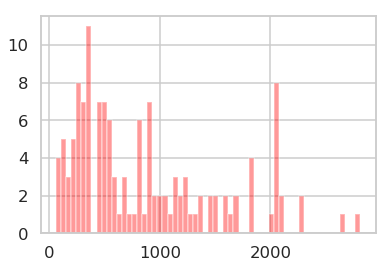

In [15]:
drug_feature_list = []
drug_neighbor_map = {}
selected_drug_list = []

for drug, target_list in drug_target_map.items():
    
    drug_neighbor_map[drug] = set()
    
    for gene in target_list:
        
        if gene not in gene_exp_neighbor_map and gene not in gene_neighbor_map:
            continue
    
        if gene in gene_exp_neighbor_map:
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_exp_neighbor_map[gene]
            
        if gene in gene_neighbor_map:
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_neighbor_map[gene]
    
    if len(drug_neighbor_map[drug]) != 0:
        selected_drug_list.append(drug)
        drug_feature_list.append( len(drug_neighbor_map[drug]) )

sns.set_style("whitegrid")
sns.set_context("talk")
sns.distplot(drug_feature_list,color='r',bins=60,kde=False,norm_hist=False)

In [16]:
drugs = pd.read_csv(drug_cell_line_file, sep='\t',index_col=2)
drugs_cell_line_list = list(drugs.index.unique())
print len(drugs_cell_line_list)
drugs

#cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == 1026]
#cell_line_drug_matrix.loc[[924100,910924],'LN_IC50'].values

#cell_line_drug_matrix.loc[ [909758, 924247, 924107],'DRUG_ID' ]

1074


,DATASET_VERSION,IC50_RESULTS_ID,DRUG_ID,MAX_CONC_MICROMOLAR,LN_IC50,AUC,RMSE
COSMIC_ID,,,,,,,
924100,17,335,1026,1.00,0.717722,0.899410,0.105665
924100,17,336,1028,2.00,2.664100,0.957206,0.178243
924100,17,337,1029,2.00,3.336828,0.973893,0.079845
924100,17,338,1030,10.00,5.164909,0.977844,0.094228
924100,17,339,1031,0.20,-4.325309,0.508180,0.090478
...,...,...,...,...,...,...,...
909907,17,226218,1053,4.00,1.282224,0.809102,0.157131
909907,17,226219,1054,4.00,5.480756,0.982976,0.027090
909907,17,226220,1057,0.25,-0.138981,0.904217,0.031997


In [17]:
cell_line_list = list(set(drugs_cell_line_list)&set(exp_cell_line_list)&set(mutation_cell_line_list) )
print len(cell_line_list)

962


In [18]:
cell_line_legend = pd.read_csv(cell_line_detail_file, sep='\t', index_col=1)
#print cell_line_legend

tissue_map = {}

for cell_line in cell_line_list:
    
    tissue = cell_line_legend.loc[cell_line,'Site']
    
    if tissue not in tissue_map:
        tissue_map[tissue] = []
        
    tissue_map[tissue].append(cell_line)

large_tissue_number = 0
for tissue, cell_line in tissue_map.items():
    
    if len(cell_line) >= 15:
        large_tissue_number += 1
    
    print tissue, len(cell_line)

print 'How many tissues', len(tissue_map)
print 'Large tissues', large_tissue_number

'''
file_handle = open(data_file + "sanger_tissue_cell_line_list.pkl","wb")
pickle.dump(tissue_map,file_handle)
file_handle.close()
'''

large_intestine 48
vulva 3
pleura 21
endometrium 11
lung 169
skin 55
autonomic_ganglia 29
kidney 31
thyroid 15
cervix 13
testis 2
central_nervous_system 56
oesophagus 35
NS 3
upper_aerodigestive_tract 42
biliary_tract 5
stomach 28
soft_tissue 22
urinary_tract 19
liver 16
prostate 7
pancreas 32
placenta 2
adrenal_gland 1
salivary_gland 2
small_intestine 1
haematopoietic_and_lymphoid_tissue 163
ovary 41
bone 40
breast 50
How many tissues 30
Large tissues 19


'\nfile_handle = open(data_file + "sanger_tissue_cell_line_list.pkl","wb")\npickle.dump(tissue_map,file_handle)\nfile_handle.close()\n'

In [22]:
new_data_file = ''

print mutation_df.shape, exp_df.shape

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

print np.sum(exp_stdev > exp_perc), np.sum(mut_sum > 5)#, np.sum(cnv_stdev > cnv_perc)

#new_exp_df = exp_df.loc[ cell_line_list, list(filtered_exp_gene_list) ]
#new_mutation_df = mutation_df.loc[ cell_line_list, list(filtered_mut_gene_list) ]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

#cell_line2id = dict(zip(cell_line_list, range(len(cell_line_list))))

rename_selected_drug_list = []

for drug in selected_drug_list:
    
#     if drug != 'Nutlin-3a (-)':
#         continue
    
    if drug not in drug2id_mapping:
        print 'drug name wrong', drug
        sys.exit(1)
    
    cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == drug2id_mapping[drug]]
    
    #print cell_line_drug_matrix
    
    feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
    feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
    
    if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
        continue
    
    feature_description = []
    
    drug_tissue_map = {}
    
    drug = drug.replace(' ','_')
    
    rename_selected_drug_list.append(drug)
    
    print drug
    if drug == 'Nutlin-3a_(-)':
        drug = 'Nutlin-3a'
    
    drug_folder = 'drug_feature/' + drug + '/'
    if not os.path.exists(drug_folder):
        os.makedirs(drug_folder)
        
    print 'Generate features', drug
    
    for tissue, tissue_cell_line_list in tissue_map.items():
        
        drug_specific_cell_line = set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )
        
        drug_tissue_map[tissue] = drug_specific_cell_line
        
        feature_list = []
        
        if len(feature_exp_gene_list) != 0:
            feature_list.append( new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values )
            for gene in feature_exp_gene_list:
                feature_description.append(gene+'_expression')
        
        if len(feature_mut_gene_list) != 0:
            feature_list.append( mutation_df.loc[ drug_specific_cell_line, feature_mut_gene_list ].values )
            for gene in feature_mut_gene_list:
                feature_description.append(gene+'_mutation')
            
        feature = np.concatenate(feature_list, axis=1)
        
        label = cell_line_drug_matrix.loc[ drug_specific_cell_line,'LN_IC50'].values
        
        #label = new_crispr_df.loc[ tissue_cell_line_list, label_gene ].values
    
        print feature.shape, label.shape
     
        np.save(drug_folder + tissue + '_' + drug + '_feature.npy', feature )
        np.save(drug_folder + tissue + '_' + drug + '_label.npy', label)
        np.save(drug_folder + tissue + '_feature_description.npy', np.asarray(feature_description))
        
    file_handle = open(new_data_file + drug+'_tissue_cell_line_list.pkl',"wb")
    pickle.dump(drug_tissue_map,file_handle)
    file_handle.close()
    
file_handle = open('rename_selected_drug_list', 'w')
for drug in rename_selected_drug_list:
    file_handle.writelines(drug+ '\n')
file_handle.close()


(1001, 19100) (1014, 17419)
15677 16794
XMD11-85h
Generate features XMD11-85h
(36, 2549) (36,)
(0, 2549) (0,)
(16, 2549) (16,)
(9, 2549) (9,)
(81, 2549) (81,)
(35, 2549) (35,)
(20, 2549) (20,)
(19, 2549) (19,)
(12, 2549) (12,)
(2, 2549) (2,)
(2, 2549) (2,)
(30, 2549) (30,)
(21, 2549) (21,)
(1, 2549) (1,)
(17, 2549) (17,)
(2, 2549) (2,)
(13, 2549) (13,)
(10, 2549) (10,)
(7, 2549) (7,)
(4, 2549) (4,)
(4, 2549) (4,)
(11, 2549) (11,)
(1, 2549) (1,)
(0, 2549) (0,)
(1, 2549) (1,)
(1, 2549) (1,)
(51, 2549) (51,)
(28, 2549) (28,)
(27, 2549) (27,)
(25, 2549) (25,)
Tubastatin_A
Generate features Tubastatin_A
(46, 804) (46,)
(3, 804) (3,)
(19, 804) (19,)
(11, 804) (11,)
(155, 804) (155,)
(53, 804) (53,)
(29, 804) (29,)
(29, 804) (29,)
(15, 804) (15,)
(12, 804) (12,)
(2, 804) (2,)
(56, 804) (56,)
(35, 804) (35,)
(3, 804) (3,)
(40, 804) (40,)
(5, 804) (5,)
(23, 804) (23,)
(19, 804) (19,)
(19, 804) (19,)
(16, 804) (16,)
(6, 804) (6,)
(31, 804) (31,)
(2, 804) (2,)
(1, 804) (1,)
(2, 804) (2,)
(1, 804)

(38, 844) (38,)
(47, 844) (47,)
THZ-2-102-1
Generate features THZ-2-102-1
(45, 939) (45,)
(3, 939) (3,)
(19, 939) (19,)
(11, 939) (11,)
(151, 939) (151,)
(49, 939) (49,)
(29, 939) (29,)
(30, 939) (30,)
(11, 939) (11,)
(12, 939) (12,)
(2, 939) (2,)
(55, 939) (55,)
(35, 939) (35,)
(3, 939) (3,)
(40, 939) (40,)
(5, 939) (5,)
(22, 939) (22,)
(19, 939) (19,)
(19, 939) (19,)
(15, 939) (15,)
(6, 939) (6,)
(31, 939) (31,)
(2, 939) (2,)
(1, 939) (1,)
(2, 939) (2,)
(1, 939) (1,)
(141, 939) (141,)
(39, 939) (39,)
(38, 939) (38,)
(47, 939) (47,)
CUDC-101
Generate features CUDC-101
(46, 3700) (46,)
(3, 3700) (3,)
(19, 3700) (19,)
(10, 3700) (10,)
(153, 3700) (153,)
(53, 3700) (53,)
(27, 3700) (27,)
(29, 3700) (29,)
(15, 3700) (15,)
(12, 3700) (12,)
(2, 3700) (2,)
(52, 3700) (52,)
(35, 3700) (35,)
(3, 3700) (3,)
(39, 3700) (39,)
(5, 3700) (5,)
(22, 3700) (22,)
(19, 3700) (19,)
(19, 3700) (19,)
(16, 3700) (16,)
(6, 3700) (6,)
(30, 3700) (30,)
(2, 3700) (2,)
(1, 3700) (1,)
(2, 3700) (2,)
(1, 3700) (1,

(22, 2490) (22,)
(12, 2490) (12,)
BHG712
Generate features BHG712
(46, 367) (46,)
(3, 367) (3,)
(19, 367) (19,)
(11, 367) (11,)
(154, 367) (154,)
(53, 367) (53,)
(29, 367) (29,)
(30, 367) (30,)
(15, 367) (15,)
(12, 367) (12,)
(2, 367) (2,)
(56, 367) (56,)
(35, 367) (35,)
(3, 367) (3,)
(40, 367) (40,)
(5, 367) (5,)
(23, 367) (23,)
(20, 367) (20,)
(19, 367) (19,)
(16, 367) (16,)
(6, 367) (6,)
(31, 367) (31,)
(2, 367) (2,)
(1, 367) (1,)
(2, 367) (2,)
(1, 367) (1,)
(141, 367) (141,)
(39, 367) (39,)
(38, 367) (38,)
(48, 367) (48,)
BMS-536924
Generate features BMS-536924
(15, 652) (15,)
(2, 652) (2,)
(3, 652) (3,)
(3, 652) (3,)
(61, 652) (61,)
(19, 652) (19,)
(24, 652) (24,)
(11, 652) (11,)
(2, 652) (2,)
(0, 652) (0,)
(2, 652) (2,)
(25, 652) (25,)
(11, 652) (11,)
(1, 652) (1,)
(4, 652) (4,)
(3, 652) (3,)
(8, 652) (8,)
(8, 652) (8,)
(2, 652) (2,)
(0, 652) (0,)
(2, 652) (2,)
(2, 652) (2,)
(1, 652) (1,)
(0, 652) (0,)
(1, 652) (1,)
(1, 652) (1,)
(140, 652) (140,)
(4, 652) (4,)
(22, 652) (22,)
(1

(40, 1535) (40,)
BI-2536
Generate features BI-2536
(15, 3682) (15,)
(2, 3682) (2,)
(3, 3682) (3,)
(3, 3682) (3,)
(61, 3682) (61,)
(19, 3682) (19,)
(24, 3682) (24,)
(11, 3682) (11,)
(2, 3682) (2,)
(0, 3682) (0,)
(2, 3682) (2,)
(24, 3682) (24,)
(11, 3682) (11,)
(1, 3682) (1,)
(4, 3682) (4,)
(3, 3682) (3,)
(8, 3682) (8,)
(8, 3682) (8,)
(2, 3682) (2,)
(0, 3682) (0,)
(2, 3682) (2,)
(2, 3682) (2,)
(1, 3682) (1,)
(0, 3682) (0,)
(1, 3682) (1,)
(1, 3682) (1,)
(139, 3682) (139,)
(4, 3682) (4,)
(22, 3682) (22,)
(12, 3682) (12,)
SB590885
Generate features SB590885
(39, 478) (39,)
(3, 478) (3,)
(15, 478) (15,)
(7, 478) (7,)
(134, 478) (134,)
(41, 478) (41,)
(28, 478) (28,)
(23, 478) (23,)
(12, 478) (12,)
(12, 478) (12,)
(1, 478) (1,)
(49, 478) (49,)
(31, 478) (31,)
(3, 478) (3,)
(36, 478) (36,)
(4, 478) (4,)
(23, 478) (23,)
(15, 478) (15,)
(15, 478) (15,)
(13, 478) (13,)
(7, 478) (7,)
(24, 478) (24,)
(2, 478) (2,)
(0, 478) (0,)
(1, 478) (1,)
(1, 478) (1,)
(155, 478) (155,)
(40, 478) (40,)
(38, 478)

WZ-1-84
Generate features WZ-1-84
(15, 389) (15,)
(2, 389) (2,)
(3, 389) (3,)
(3, 389) (3,)
(61, 389) (61,)
(19, 389) (19,)
(24, 389) (24,)
(11, 389) (11,)
(2, 389) (2,)
(0, 389) (0,)
(2, 389) (2,)
(25, 389) (25,)
(11, 389) (11,)
(1, 389) (1,)
(4, 389) (4,)
(3, 389) (3,)
(8, 389) (8,)
(8, 389) (8,)
(2, 389) (2,)
(0, 389) (0,)
(2, 389) (2,)
(2, 389) (2,)
(1, 389) (1,)
(0, 389) (0,)
(1, 389) (1,)
(1, 389) (1,)
(139, 389) (139,)
(4, 389) (4,)
(22, 389) (22,)
(12, 389) (12,)
Parthenolide
Generate features Parthenolide
(15, 1629) (15,)
(2, 1629) (2,)
(3, 1629) (3,)
(2, 1629) (2,)
(64, 1629) (64,)
(19, 1629) (19,)
(25, 1629) (25,)
(10, 1629) (10,)
(2, 1629) (2,)
(1, 1629) (1,)
(2, 1629) (2,)
(27, 1629) (27,)
(9, 1629) (9,)
(1, 1629) (1,)
(3, 1629) (3,)
(2, 1629) (2,)
(9, 1629) (9,)
(7, 1629) (7,)
(2, 1629) (2,)
(0, 1629) (0,)
(2, 1629) (2,)
(2, 1629) (2,)
(1, 1629) (1,)
(0, 1629) (0,)
(1, 1629) (1,)
(1, 1629) (1,)
(139, 1629) (139,)
(4, 1629) (4,)
(23, 1629) (23,)
(14, 1629) (14,)
681640
Gen

(141, 259) (141,)
(39, 259) (39,)
(38, 259) (38,)
(48, 259) (48,)
Pyrimethamine
Generate features Pyrimethamine
(15, 296) (15,)
(2, 296) (2,)
(3, 296) (3,)
(2, 296) (2,)
(62, 296) (62,)
(19, 296) (19,)
(25, 296) (25,)
(10, 296) (10,)
(2, 296) (2,)
(0, 296) (0,)
(2, 296) (2,)
(27, 296) (27,)
(9, 296) (9,)
(1, 296) (1,)
(3, 296) (3,)
(2, 296) (2,)
(9, 296) (9,)
(8, 296) (8,)
(2, 296) (2,)
(0, 296) (0,)
(2, 296) (2,)
(2, 296) (2,)
(1, 296) (1,)
(0, 296) (0,)
(1, 296) (1,)
(1, 296) (1,)
(140, 296) (140,)
(4, 296) (4,)
(23, 296) (23,)
(14, 296) (14,)
SL_0101-1
Generate features SL_0101-1
(38, 1545) (38,)
(3, 1545) (3,)
(15, 1545) (15,)
(9, 1545) (9,)
(136, 1545) (136,)
(45, 1545) (45,)
(28, 1545) (28,)
(22, 1545) (22,)
(13, 1545) (13,)
(9, 1545) (9,)
(1, 1545) (1,)
(51, 1545) (51,)
(31, 1545) (31,)
(2, 1545) (2,)
(36, 1545) (36,)
(4, 1545) (4,)
(25, 1545) (25,)
(17, 1545) (17,)
(15, 1545) (15,)
(11, 1545) (11,)
(7, 1545) (7,)
(25, 1545) (25,)
(2, 1545) (2,)
(1, 1545) (1,)
(1, 1545) (1,)
(1,

(48, 1747) (48,)
Embelin
Generate features Embelin
(38, 531) (38,)
(3, 531) (3,)
(20, 531) (20,)
(10, 531) (10,)
(152, 531) (152,)
(52, 531) (52,)
(27, 531) (27,)
(23, 531) (23,)
(15, 531) (15,)
(12, 531) (12,)
(2, 531) (2,)
(50, 531) (50,)
(27, 531) (27,)
(2, 531) (2,)
(42, 531) (42,)
(5, 531) (5,)
(22, 531) (22,)
(21, 531) (21,)
(19, 531) (19,)
(16, 531) (16,)
(6, 531) (6,)
(31, 531) (31,)
(2, 531) (2,)
(1, 531) (1,)
(2, 531) (2,)
(1, 531) (1,)
(142, 531) (142,)
(27, 531) (27,)
(37, 531) (37,)
(48, 531) (48,)
OSU-03012
Generate features OSU-03012
(37, 631) (37,)
(3, 631) (3,)
(20, 631) (20,)
(10, 631) (10,)
(152, 631) (152,)
(52, 631) (52,)
(27, 631) (27,)
(23, 631) (23,)
(15, 631) (15,)
(12, 631) (12,)
(2, 631) (2,)
(50, 631) (50,)
(27, 631) (27,)
(2, 631) (2,)
(42, 631) (42,)
(5, 631) (5,)
(22, 631) (22,)
(21, 631) (21,)
(19, 631) (19,)
(16, 631) (16,)
(6, 631) (6,)
(30, 631) (30,)
(2, 631) (2,)
(1, 631) (1,)
(2, 631) (2,)
(1, 631) (1,)
(142, 631) (142,)
(27, 631) (27,)
(37, 631) (

(48, 809) (48,)
Tipifarnib
Generate features Tipifarnib
(38, 162) (38,)
(3, 162) (3,)
(20, 162) (20,)
(10, 162) (10,)
(152, 162) (152,)
(51, 162) (51,)
(26, 162) (26,)
(23, 162) (23,)
(15, 162) (15,)
(12, 162) (12,)
(2, 162) (2,)
(50, 162) (50,)
(27, 162) (27,)
(2, 162) (2,)
(42, 162) (42,)
(5, 162) (5,)
(22, 162) (22,)
(21, 162) (21,)
(19, 162) (19,)
(16, 162) (16,)
(6, 162) (6,)
(31, 162) (31,)
(2, 162) (2,)
(1, 162) (1,)
(2, 162) (2,)
(1, 162) (1,)
(141, 162) (141,)
(27, 162) (27,)
(37, 162) (37,)
(48, 162) (48,)
HG-5-113-01
Generate features HG-5-113-01
(36, 205) (36,)
(0, 205) (0,)
(16, 205) (16,)
(8, 205) (8,)
(81, 205) (81,)
(35, 205) (35,)
(20, 205) (20,)
(18, 205) (18,)
(12, 205) (12,)
(2, 205) (2,)
(2, 205) (2,)
(31, 205) (31,)
(21, 205) (21,)
(1, 205) (1,)
(17, 205) (17,)
(2, 205) (2,)
(13, 205) (13,)
(10, 205) (10,)
(7, 205) (7,)
(4, 205) (4,)
(4, 205) (4,)
(11, 205) (11,)
(1, 205) (1,)
(0, 205) (0,)
(1, 205) (1,)
(1, 205) (1,)
(51, 205) (51,)
(28, 205) (28,)
(28, 205) (28,

(1, 1676) (1,)
(139, 1676) (139,)
(4, 1676) (4,)
(22, 1676) (22,)
(12, 1676) (12,)
RO-3306
Generate features RO-3306
(39, 2167) (39,)
(3, 2167) (3,)
(14, 2167) (14,)
(9, 2167) (9,)
(138, 2167) (138,)
(45, 2167) (45,)
(28, 2167) (28,)
(23, 2167) (23,)
(13, 2167) (13,)
(13, 2167) (13,)
(1, 2167) (1,)
(51, 2167) (51,)
(31, 2167) (31,)
(3, 2167) (3,)
(36, 2167) (36,)
(4, 2167) (4,)
(25, 2167) (25,)
(17, 2167) (17,)
(15, 2167) (15,)
(13, 2167) (13,)
(7, 2167) (7,)
(25, 2167) (25,)
(2, 2167) (2,)
(1, 2167) (1,)
(1, 2167) (1,)
(1, 2167) (1,)
(155, 2167) (155,)
(40, 2167) (40,)
(38, 2167) (38,)
(44, 2167) (44,)
QL-XI-92
Generate features QL-XI-92
(46, 1760) (46,)
(3, 1760) (3,)
(20, 1760) (20,)
(11, 1760) (11,)
(154, 1760) (154,)
(53, 1760) (53,)
(29, 1760) (29,)
(30, 1760) (30,)
(15, 1760) (15,)
(12, 1760) (12,)
(2, 1760) (2,)
(56, 1760) (56,)
(35, 1760) (35,)
(3, 1760) (3,)
(40, 1760) (40,)
(5, 1760) (5,)
(23, 1760) (23,)
(20, 1760) (20,)
(19, 1760) (19,)
(16, 1760) (16,)
(6, 1760) (6,)
(31,

In [27]:
len(drug_specific_cell_line)

46

In [31]:
len(drug_tissue_map['breast'])

46

In [35]:
import pickle

In [37]:
cell_line_loc = '/cellar/users/samsonfong/Projects/tcrp-v2/from-ma/cell_line_lists/'

In [38]:
with open(cell_line_loc + 'KU-55933_tissue_cell_line_list.pkl', 'rb') as f: 
    tmap= pickle.load(f)

In [48]:
tmap.keys()

['large_intestine',
 'vulva',
 'pleura',
 'endometrium',
 'lung',
 'skin',
 'autonomic_ganglia',
 'kidney',
 'thyroid',
 'cervix',
 'testis',
 'central_nervous_system',
 'oesophagus',
 'NS',
 'upper_aerodigestive_tract',
 'biliary_tract',
 'stomach',
 'soft_tissue',
 'urinary_tract',
 'liver',
 'prostate',
 'pancreas',
 'placenta',
 'adrenal_gland',
 'salivary_gland',
 'small_intestine',
 'haematopoietic_and_lymphoid_tissue',
 'ovary',
 'bone',
 'breast']

In [49]:
len(tmap['lung'])

137

In [50]:
f = np.load('/cellar/users/samsonfong/Projects/tcrp-v2/from-ma/drug_feature/KU-55933/lung_KU-55933_feature.npy')

In [51]:
f.shape

(137, 1502)